In [14]:
import sys
import os
import warnings
from config import *

sys.path.append(f"{ROOT}")

warnings.filterwarnings("ignore")

In [15]:
import numpy as np
import pandas as pd
import time
import pickle
import warnings
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="muted")

import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.nn import functional as F

from ss_inference.data import SecondaryStructureRawDataset, collate_sequences
from ss_inference.model import NetSurfP2, ConvNet

from utils import *
from pattern_matching.data_extraction import from_fasta_to_df, from_df_to_fasta
from pattern_matching.pattern import PatternMatching, Matching

from config import DATA
from pgm.data import SequenceData, SequenceStructureData
from pgm.layers import GaussianLayer, OneHotLayer, DReLULayer
from pgm.edge import Edge
from pgm.model import MRF
from pgm.utils import *

torch.cuda.is_available()

True

In [16]:
all_files = [f[:-3] for f in os.listdir(f"{DATA}/{DATASET}/gen_data") if f[-3:] == ".pt"]
all_files

['rbm_local_rejection_sampling_T_0.5',
 'ind_local_rejection_sampling_T_3',
 'ind_rejection_sampling_T_10000',
 'ind_local_rejection_sampling_T_0.5',
 'rbm_rejection_sampling_T_0.1',
 'rbm_rejection_sampling_T_100',
 'rbm_local_rejection_sampling_T_10000',
 'rbm_rejection_sampling_T_0.5',
 'ind_rejection_sampling_T_1',
 'rbm_rejection_sampling_T_10',
 'rbm_rejection_sampling_T_20',
 'ind_rejection_sampling_T_3',
 'ind_rejection_sampling_T_0.5',
 'rbm_rejection_sampling_T_60',
 'ind_local_rejection_sampling_T_10000',
 'rbm_rejection_sampling_T_10000',
 'rbm_rejection_sampling_T_30',
 'ind_rejection_sampling_T_30',
 'rbm_rejection_sampling_T_0.05',
 'ind_rejection_sampling_T_0.1',
 'natural',
 'ind_rejection_sampling_T_0.05',
 'ind_rejection_sampling_T_60',
 'rbm_rejection_sampling_T_5',
 'rbm_local_rejection_sampling_T_1',
 'rbm_local_rejection_sampling_T_3',
 'ind_rejection_sampling_T_5',
 'ind_rejection_sampling_T_10',
 'rbm_rejection_sampling_T_3',
 'ind_rejection_sampling_T_20',
 'i

In [17]:
DATASET = "PF07736"

batch_size = 300

all_files = ['natural',
 'ind_rejection_sampling_T_0.05',
 'ind_rejection_sampling_T_1',
 'ind_rejection_sampling_T_10000',
 'rbm_rejection_sampling_T_0.05',
 'rbm_rejection_sampling_T_1',
 'rbm_rejection_sampling_T_10000',
  "rbm_local_rejection_sampling_T_3",
 'rbm_local_rejection_sampling_T_0.5']

## Data

In [18]:
dataset = SequenceData(f"{DATA}/{DATASET}", dataset="full")
loader = DataLoader(dataset, batch_size = 100, 
                          shuffle = False)

In [19]:
device = torch.device('cuda')

model_ss3 = NetSurfP2(50, "netsurfp2")
model_ss3.load_state_dict(torch.load(f"{DATA}/secondary_structure/lstm_50feats.h5"))
model_ss3 = model_ss3.eval()
model_ss3 = model_ss3.to(device)

model_ss3

Model netsurfp2-50

In [20]:
seq_hmm = torch.tensor(dataset[0][3]).t()[20:]
torch.save(seq_hmm, f"{DATA}/{DATASET}/hmm.pt")
_, size = seq_hmm.size()

In [21]:
n_patterns, c_patterns, _ =  pickle.load(open(f"{DATA}/{DATASET}/patterns.pkl","rb"))
regexes = []
for x in n_patterns:
    if len(x):
        regexes.append([(i,None,None) for i in x])
size = 150
Q = np.ones((3, size+1, size+1)) * (-np.inf)
e = size
for i in range(size+1):
    Q[:3, i, i+1:] = 0
Q = Q.reshape(1, *Q.shape)

ss_hmm = pickle.load(open(f"{DATA}/{DATASET}/ss_profile.pkl", "rb"))
seq_hmm = torch.load(f"{DATA}/{DATASET}/hmm.pt")

matcher = PatternMatching(model_ss3, pattern = regexes[1], Q = Q ,
                          seq_hmm = seq_hmm, ss_hmm = ss_hmm, 
                          size = size, name = c_patterns[1])

In [22]:
len_pat = len(matcher.pattern)
ll_, t_, ls_, M_, p_, L_ = [],[],[],[],[],[]

for filename in all_files:
    ll, p, t, ls, M, L = [],[],[],[],[],[]
    x = torch.load(f"{DATA}/{DATASET}/gen_data/{filename}.pt")
    for i in tqdm(range(len(x)//batch_size + 1)):
        torch.cuda.empty_cache()
        m = Matching(x[batch_size*i:batch_size*(i+1)])
        matcher(m)
        t.append(m.t)
        L.append(m.L)
        ls.append(m.ls)
        M.append(m.M)
        del m
    t_.append(torch.cat(t,0))
    ls_.append(torch.cat(ls,0))
    M_.append(torch.cat(M,0))
    L_.append(torch.cat(L,0))
        torch.cuda.empty_cache()
        m = Matching(x[batch_size*i:batch_size*(i+1)])
        matcher(m)
        t.append(m.t)
        L.append(m.L)
        ls.append(m.ls)
        M.append(m.M)
        del m
    t_.append(torch.cat(t,0))
    ls_.append(torch.cat(ls,0))
    M_.append(torch.cat(M,0))
    L_.append(torch.cat(L,0))
t_ = torch.cat([t.view(1, *t.size()) for t in t_],0)
ls_ = torch.cat([t.view(1, *t.size()) for t in ls_],0)
M_ = torch.cat([t.view(1, *t.size()) for t in M_],0)
L_ = torch.cat([t.view(1, *t.size()) for t in L_],0)

100%|██████████| 7/7 [00:34<00:00,  4.89s/it]


## Analysis

In [23]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.neighbors import KernelDensity

In [24]:
u = torch.arange(30).reshape(1,1,1,30)
X = (L_*u).sum(-1)

In [25]:
idxs = X[0].std(0)/X[0].mean(0) < np.inf
scaler = RobustScaler()
scaler.fit(X[0])
X_n = np.zeros((*X.shape[:-1], sum(idxs)))
#m, s = mode(X[0]).view(1,-1), X[0].std(0).view(1,-1)
for i in range(len(all_files)):
    X_n[i] = scaler.transform(X[i])
    #X_n[i] = ((X[i]-m)/s)[:,idxs]

In [ ]:
m, M = -5,5
x = np.linspace(m,M,50)
for i, file in enumerate(all_files):
    print(file)
    plt.figure(figsize = (15, 8))
    for j in range(7):
        plt.subplot(2, 4, j+1)
        plt.hist(X_n[i,:,j], bins = x, density=True)
        plt.title(f"beta 1 (m = {X_n[i,:,j].mean():.2f}, std = {X_n[i,:,j].std():.2f})")
        plt.xlim(m,M)
        plt.ylim(0, 1.3)
    
    
    plt.subplot(2, 4, 8)
    plt.hist(X_max[i,:], bins = x, density=True)
    plt.xlim(0,5)
    plt.ylim(0, 1.)
    plt.title(f"worst beta (m = {X_max[i,:].mean():.2f}, std = {X_max[i,:].std():.2f})")

    plt.show()

In [ ]:
stds = np.zeros((len(all_files), 7, 6))
for i, x in enumerate(X_n):
    for j in range(6):
        stds[i, :, j] = (np.abs(x)>=j).mean(0)

for i in range(7):
    plt.figure(figsize=(8,8))
    for s in stds:
        plt.plot(np.log(s[i]+np.exp(-8)))
        plt.ylim(-8, 0)
    plt.legend(all_files)
    plt.show()

### Max divergence

In [40]:
X_max = np.max(np.abs(X_n), 2)
x = np.linspace(0,5,100)
stds_max = np.zeros((len(all_files), len(x)))
for i, y in enumerate(X_max):
    for j, t in enumerate(x):
        stds_max[i, j] = (np.abs(y)>=t).mean()

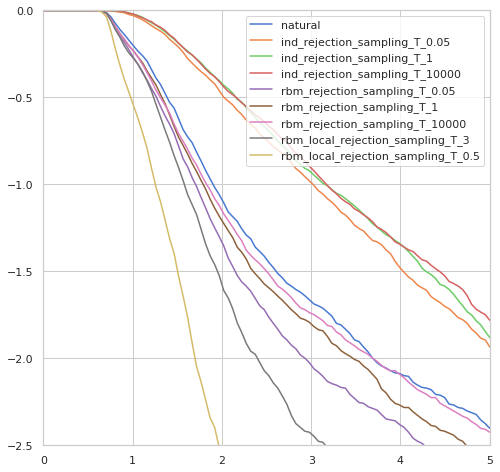

In [41]:
plt.figure(figsize=(8,8))
for s in stds_max:
    plt.plot(x, np.log(s+1e-28))
    plt.xlim(0,5)
    plt.ylim(-2.5, 0)
plt.legend(all_files)
plt.show()

In [36]:
gm = KernelDensity(bandwidth=0.5, algorithm='auto', kernel='gaussian').fit(X[0])
gm_scores = np.zeros((len(all_files), len(X[0])))
for i, y in enumerate(X):
    gm_scores[i] = gm.score_samples(y)

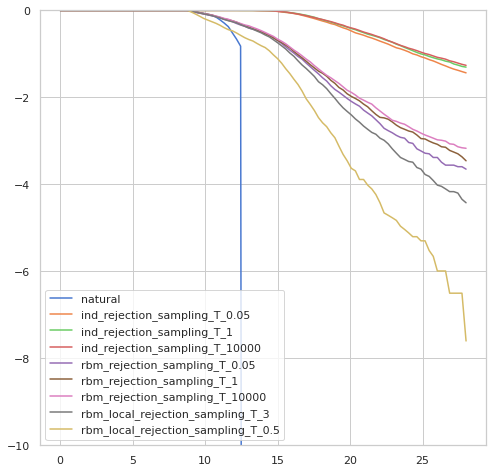

In [38]:
x = np.linspace(0,28,100)
stds_max = np.zeros((len(all_files), len(x)))
for i, y in enumerate(gm_scores):
    for j, t in enumerate(x):
        stds_max[i, j] = (np.abs(y)>=t).mean()

plt.figure(figsize=(8,8))
for s in stds_max:
    plt.ylim(-10,0)
    plt.plot(x, np.log(s+1e-28))
plt.legend(all_files)
plt.show()

In [30]:
gms = [KernelDensity(bandwidth=0.5, algorithm='auto', kernel='gaussian').fit(X[0,:,i:i+1]) for i in range(22)]

gm_scores = np.zeros((len(all_files), 2000, 22))
for k,gm in enumerate(gms):
    X_ = X[:,:,k]
    for i, y in enumerate(X_):
        gm_scores[i,:,k] = gm.score_samples(y.reshape((len(y), 1))).reshape(len(y))
        
gm_scores_max = gm_scores.min(-1)

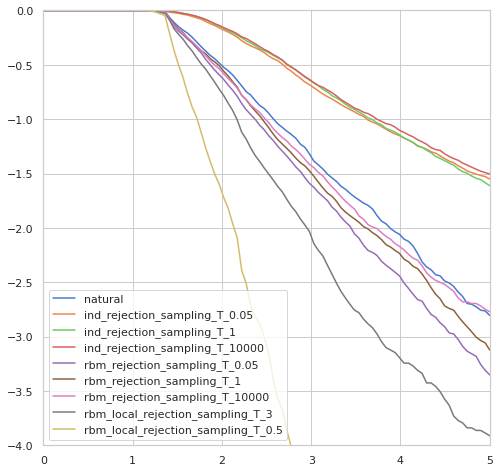

In [39]:
x = np.linspace(0,5,100)
stds_max = np.zeros((len(all_files), len(x)))
for i, y in enumerate(gm_scores_max):
    for j, t in enumerate(x):
        stds_max[i, j] = (np.abs(y)>=t).mean()
        
plt.figure(figsize=(8,8))
for s in stds_max:
    plt.plot(x, np.log(s+1e-28))
    plt.xlim(0,5)
    plt.ylim(-4, 0)
plt.legend(all_files)
plt.show()

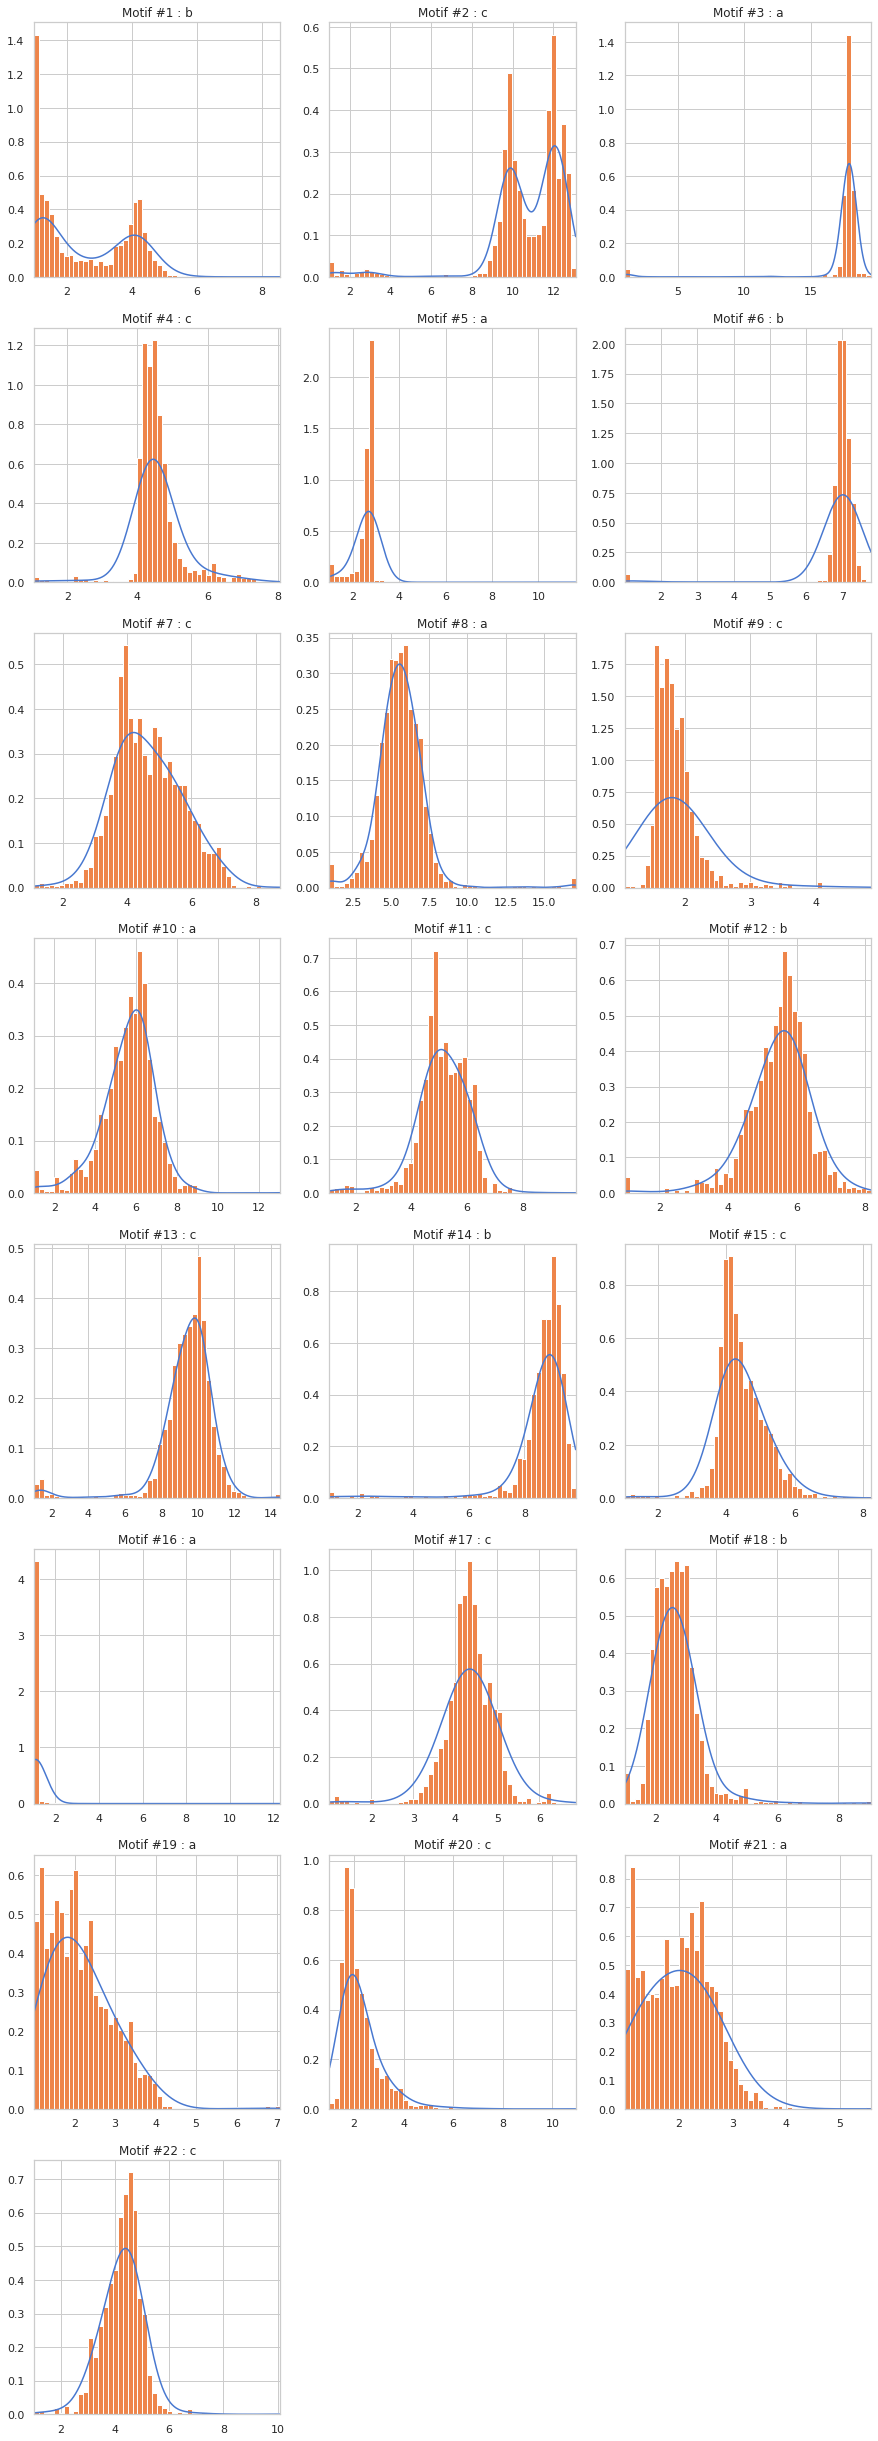

In [42]:
gms = [KernelDensity(bandwidth=0.5, algorithm='auto', kernel='gaussian').fit(X[0,:,i:i+1]) for i in range(len(c_patterns[1]))]

plt.figure(figsize = (15, 2*len(gms)))
for i,(pat, gm,y) in enumerate(zip(c_patterns[1], gms, X[0].T)):
    plt.subplot(len(gms)//3 + 1 , 3, i+1)
    m, M = y.min(), y.max()
    values = np.linspace(m, M, 500)
    values = values.reshape((len(values), 1))
    probabilities = gm.score_samples(values)
    probabilities = np.exp(probabilities)
    plt.plot(values[:], probabilities)
    plt.hist(y, bins = 50, density=True)
    plt.xlim(m,M)
    plt.title(f"Motif #{i+1} : {pat}")

plt.show()